In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import lbg_forecast.priors_gp_dust as gpdp

In [2]:
dust_prior = gpdp.DustPrior('./', mean=0)
n, tau, tau1, ne, taue, tau1e, sfr = dust_prior.n, dust_prior.tau, dust_prior.tau1, dust_prior.ne, dust_prior.taue, dust_prior.tau1e, dust_prior.sfr
recent_sfrs, dust2, dust_index, dust1 = dust_prior.recent_sfrs, dust_prior.dust2, dust_prior.dust_index, dust_prior.dust1

Loading Models
Loading Complete


<ErrorbarContainer object of 3 artists>

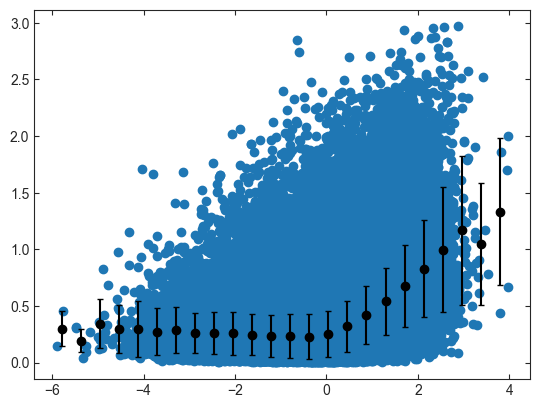

In [3]:
plt.scatter(recent_sfrs, dust2)
bin_centers, bin_means, bin_std = dust_prior.process_training_data_dust2()#gpdp.process_samples(recent_sfrs, dust2, -6, 4, 30)
plt.errorbar(bin_centers, bin_means, bin_std, fmt='ko', capsize=2)

1.4628639633946943
1.4200754468075
1.3769038844085888
1.333392280675313
1.2895847451402727
1.2455268878222585
1.2012663034654583
1.1568531122266845
1.1123404892881354
1.067785074742314
1.0232471275947714
0.9787902987655038
0.9344809422614061
0.8903869248957924
0.8465759074516871
0.8031130703609461
0.7600582914567667
0.7174628912666602
0.675366238025123
0.633792681939914
0.5927493455994283
0.5522251303453962
0.512190938773621
0.4726007874647296
0.4333934654972236
0.3944947325237352
0.3558204825105693
0.31728147499181647
0.27878999715954
0.2402682746372881
0.20165784711107446
0.16292869842234983
0.12408678762900187
0.08517874395409253
0.04629278172803423
0.007555311827679508
-0.03087671638755592
-0.06882701139770002
-0.10611320475912371
-0.14256015580883533
-0.17801112370837333
-0.21233502059270895
-0.24542877890578949
-0.27721486948066154
-0.3076349210373168
-0.33664102456751177
-0.36418657717776853
-0.39021843895425007
-0.41467181417236265
-0.43746873432220595
-0.4585204355920321
-0.47

/Users/fpetri/anaconda3/envs/tf_env/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


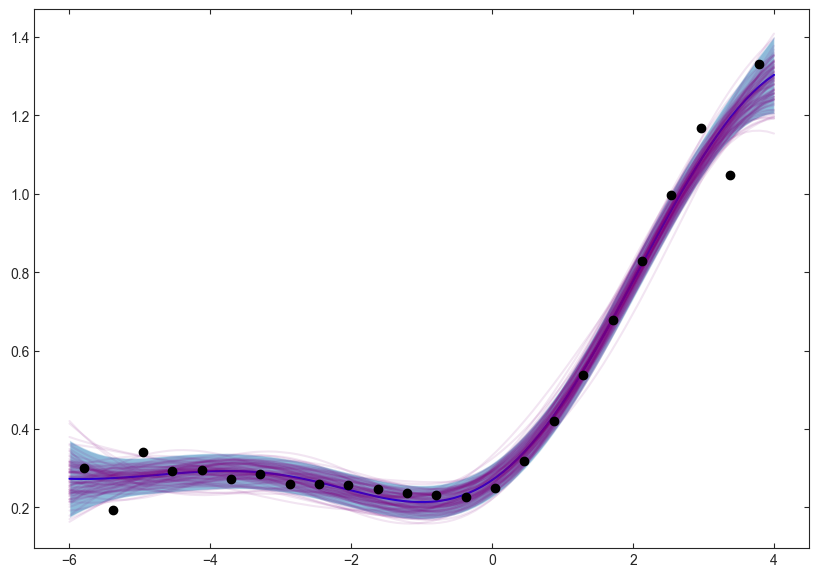

In [4]:
train_sfrs, train_dust2, train_dust2_errs = dust_prior.process_training_data_dust2()
test_sfrs = torch.linspace(-6, 4, 100)
trained_model, trained_likelihood = gpdp.train_gp_model_noerr(train_sfrs, train_dust2, [0.0, 99.0], [-100, 100], lr=0.1, training_iter=1000)
f_preds_mu = gpdp.gp_evaluate_model(trained_model, test_sfrs)
gpdp.gp_plot_confidence_obs(f_preds_mu, test_sfrs, train_sfrs, train_dust2, train_dust2_errs*0, labelx="", labely="", alpha=0.5)

for param_name, param in trained_model.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param.item()}')


with torch.no_grad():
    for i in range(100):
        plt.plot(test_sfrs, f_preds_mu.sample().numpy(), c='purple', alpha=0.1)

In [5]:
torch.save(trained_model.state_dict(), 'gp_models/dust2.pth')

<ErrorbarContainer object of 3 artists>

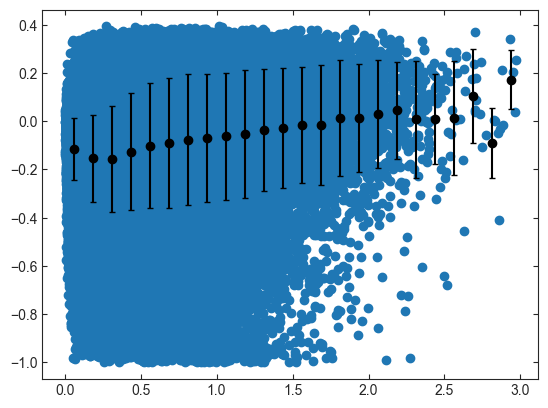

In [6]:
plt.scatter(dust2, dust_index)

bin_centers, bin_means, bin_std = dust_prior.process_training_data_dust_index()

plt.errorbar(bin_centers, bin_means, bin_std, fmt='ko', capsize=2)

1.2292260206572165
1.187634503171343
1.1455734070543564
1.103045916525245
1.0600540133494822
1.0165990694305933
0.9726826701483137
0.9283075744834464
0.8834786659229027
0.838203744878497
0.7924939923350558
0.7463640585622983
0.6998318371122142
0.6529180900946315
0.6056460427700321
0.558041049317794
0.5101303674699683
0.46194302641303797
0.41350977484057166
0.36486308314359756
0.31603716613519767
0.2670680363110281
0.2179935512319985
0.1688534737773689
0.11968954229342475
0.07054554310182054
0.021467394074186425
-0.027496762793313385
-0.07629646573935724
-0.12487884626286799
-0.17318853757596778
-0.22116761787957873
-0.26875557803526884
-0.31588934096308185
-0.36250333928511086
-0.4085296803508643
-0.4538984037885277
-0.4985378440549517
-0.5423751103778943
-0.5853366728494256
-0.6273490348407896
-0.6683394420497835
-0.7082365595028866
-0.7469710172995924
-0.7844756909387978
-0.8206855869044755
-0.8555372226556653
-0.8889674604088996
-0.920911864956193
-0.9513028280087826
-0.980067883641

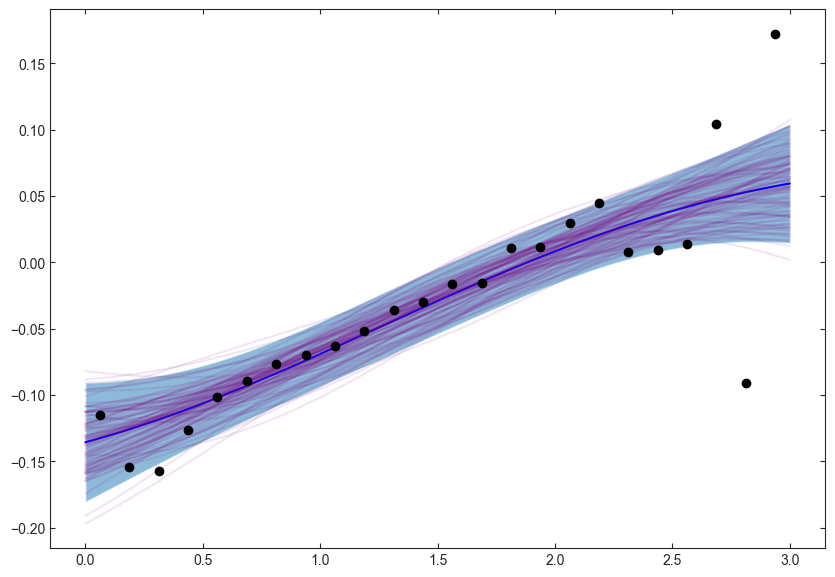

In [7]:
train_dust2, train_dust_index, train_dust_index_errs = dust_prior.process_training_data_dust_index()

test_dust2 = torch.linspace(0, 3, 100)
#train_dust2, train_dust_index, train_dust_index_errs = gpdp.training_data_to_torch(bin_centers, bin_means, bin_std, x, y, yerr)

trained_model, trained_likelihood = gpdp.train_gp_model_noerr(train_dust2, train_dust_index, [0.0, 10.0], [-100, 100], lr=0.1, training_iter=1000)
f_preds = gpdp.gp_evaluate_model(trained_model, test_dust2)
gpdp.gp_plot_confidence_obs(f_preds, test_dust2, train_dust2, train_dust_index, train_dust_index_errs*0, labelx="", labely="", alpha=0.5)
for param_name, param in trained_model.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param.item()}')

with torch.no_grad():
    for i in range(100):
        plt.plot(test_dust2, f_preds.sample().numpy(), c='purple', alpha=0.1)

In [8]:
torch.save(trained_model.state_dict(), 'gp_models/dust_index.pth')

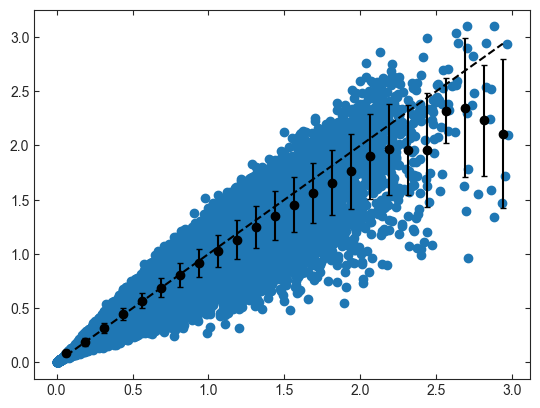

In [9]:
plt.scatter(dust2, dust1)

bin_centers, bin_means, bin_std = dust_prior.process_training_data_dust1()

plt.errorbar(bin_centers, bin_means, bin_std, fmt='ko', capsize=2)
plt.plot(bin_centers, bin_centers, c='k', ls='--')

1.4095212918050244
1.372321581428249
1.3352893630658713
1.2982487928798137
1.260817392807522
1.2228300456211463
1.1843040374667828
1.145286389196794
1.1058184592633942
1.065933501127242
1.0256589939353418
0.9850191776040417
0.944037144443107
0.9027364257794886
0.8611421084977863
0.8192815648053852
0.7771848927735334
0.734885148724255
0.6924184569084811
0.6498240446045448
0.6071442464682115
0.5644245111523736
0.5217134262418209
0.4790627696489828
0.4365276068249469
0.39416641884553777
0.35204127648463635
0.3102180359192846
0.26876656951214956
0.22776099610938294
0.1872799181032622
0.14740664056726724
0.10822934753874502
0.06984123326862497
0.03234053424958757
-0.0041695460939970745
-0.039581067354030296
-0.07378178481846269
-0.10665581868841005
-0.1380846396491302
-0.1679484169691244
-0.19612779373805278
-0.22250615765706527
-0.24697244485214043
-0.26942452750775764
-0.2897731544250351
-0.30794643371407676
-0.32389469206907123
-0.3375955521015088
-0.34905890144684043
-0.3583313641381981

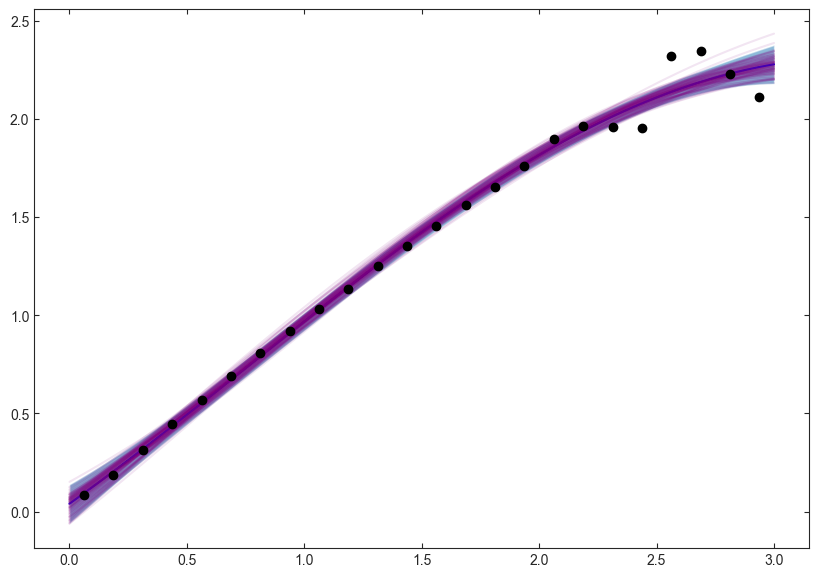

In [10]:
test_dust2 = torch.linspace(0, 3, 100)
train_dust2, train_dust1, train_dust1_errs = dust_prior.process_training_data_dust1()
trained_model, trained_likelihood = gpdp.train_gp_model_noerr(train_dust2, train_dust1, [0.0, 99.0], [-100, 100], lr=0.1, training_iter=1000)
f_preds = gpdp.gp_evaluate_model(trained_model, test_dust2)
gpdp.gp_plot_confidence_obs(f_preds, test_dust2, train_dust2, train_dust1, train_dust1_errs*0, labelx="", labely="", alpha=0.5)
for param_name, param in trained_model.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param.item()}')

with torch.no_grad():
    for i in range(100):
        plt.plot(test_dust2, f_preds.sample().numpy(), c='purple', alpha=0.1)

In [11]:
torch.save(trained_model.state_dict(), 'gp_models/dust1.pth')